In [1]:
import os
import sys
print(os.getcwd())
sys.path.append("../WanPy")

from WanPy import *
from pythtb import *
from pythTB_wan import Bloch, K_mesh, Wannier, Lattice
import models
import plotting as plot

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import LogNorm

/Users/treycole/Codes/WanPy/top_obstruction


In [2]:
# tight-binding parameters
delta = 1
# # checkerboard
# t0 = 0.4
# tprime = 0.5
# Haldane
t = 1
t2 = -0.4

n_super_cell = 2
model = models.Haldane(delta, t, t2).make_supercell([[n_super_cell, 0], [0, n_super_cell]])
# model = models.chessboard(t0, tprime, delta).make_supercell([[n_super_cell, 0], [0, n_super_cell]])
# model.display()

In [3]:
low_E_sites = np.arange(0, model.get_num_orbitals(), 2)
high_E_sites = np.arange(1, model.get_num_orbitals(), 2)
lat_vecs = model.get_lat()
orb_vecs = model.get_orb()

n_orb = model.get_num_orbitals()
n_occ = int(n_orb/2)

u_wfs_full = wf_array(model, [20, 20])
u_wfs_full.solve_on_grid([0, 0])
chern = u_wfs_full.berry_flux([i for i in range(n_occ)])/(2*np.pi)

print(f"Low energy sites: {low_E_sites}")
print(f"High energy sites: {high_E_sites}")
print(f"Chern # occupied: {chern: .1f}")

Low energy sites: [0 2 4 6]
High energy sites: [1 3 5 7]
Chern # occupied:  1.0


In [4]:
random = False
low_E = False
omit = True

if random:
    omit_num = 1
    n_tfs = n_occ - omit_num
    tf_list = ["random", n_tfs]
elif omit:
    omit_sites = 0
    tf_list = list(np.setdiff1d(low_E_sites, [omit_sites])) # delta on lower energy sites omitting the last site
    # np.random.choice(low_E_sites, n_tfs, replace=False)
    n_tfs = len(tf_list)
elif low_E:
    tf_list = list(low_E_sites)
    n_tfs = len(tf_list)

Wan_frac = n_tfs/n_occ
print(f"Trial wavefunctions: {tf_list}")
print(f"# of Wannier functions: {n_tfs}")
print(f"# of occupied bands: {n_occ}")
print(f"Wannier fraction: {Wan_frac}")

Trial wavefunctions: [np.int64(2), np.int64(4), np.int64(6)]
# of Wannier functions: 3
# of occupied bands: 4
Wannier fraction: 0.75


In [5]:
save_name = f'C={chern:.1f}_Delta={delta}_t={t}_t2={t2}'

if random:
    save_name += '_tfxs=rand'
else:
    save_name += f'_tfx={np.array(tf_list, dtype=int)}'
save_name

'C=1.0_Delta=1_t=1_t2=-0.4_tfx=[2 4 6]'

In [6]:
sv_dir = 'data'
if not os.path.exists(sv_dir):
    os.makedirs(sv_dir)
sv_prefix = 'WF_max_loc'
file_name = f"{sv_dir}/{sv_prefix}_{save_name}"
file_name

'data/WF_max_loc_C=1.0_Delta=1_t=1_t2=-0.4_tfx=[2 4 6]'

In [7]:
# WF = np.load(f"{sv_dir}/{sv_prefix}_{save_name}.npy", allow_pickle=True).item()
file_name = f"data/WF_max_loc_C=1.0_Delta=1_t=1_t2=-0.4_tfx={np.array(tf_list, dtype=int)}.npy"
# file_name = "/Users/treycole/Codes/WanPy/top_obstruction/data/WF_max_loc_C=1.0_Delta=1_t=1_t2=-0.4_tfxs=rand.npy"
WF = np.load(f"{file_name}", allow_pickle=True).item()

In [8]:
WF.report()

Wannier function report
 --------------------- 
Quadratic spreads:
w_0 --> 0.23414
w_1 --> 0.23414
w_2 --> 0.23414
Centers:
w_0 --> [0.17941 0.6603 ]
w_1 --> [0.6603  0.17941]
w_2 --> [0.6603 0.6603]
Omega_i = 0.6577988768599141
Omega_tilde = 0.04460694512972264


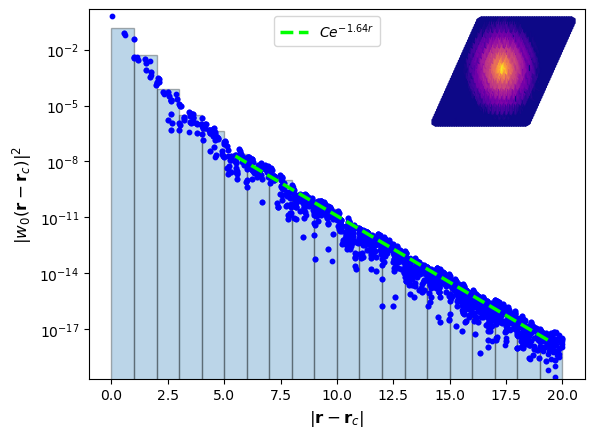

In [30]:
idx = 0
fig, ax = WF.plot_decay(idx, fit_rng=[5, 20], return_fig=True)
ax.legend(bbox_to_anchor=(0.6, 1.0))
inset_ax = inset_axes(ax, width="30%", height="30%", loc='upper right')  # You can adjust size and location
fig, inset_ax = WF.plot_density(idx, show_lattice=False, lat_size=2, cbar=False, fig=fig, ax=inset_ax, return_fig=True)
inset_ax.set_xticks([])
inset_ax.set_yticks([])
inset_ax.axis('off')
plt.savefig(f'images/decay_and_dens_{save_name}.png', dpi=700)

In [12]:
def plot_centers(
        WF, mark_home_cell=False, 
        omit_sites=None, translate_centers=False,
        title=None, save_name=None, 
        show=False, legend=False,
        kwargs_centers={'s': 80, 'marker': '*', 'c': 'g'},
        kwargs_omit={'s': 50, 'marker': 'x', 'c':'k'},
        kwargs_lat={'s':10, 'marker': 'o', 'c':'k'}

    ):

    orbs = WF.Lattice._orbs
    lat_vecs = WF.Lattice._lat_vecs
    w0 = WF.WFs
    centers = WF.centers

    nx, ny = w0.shape[0], w0.shape[1]

    supercell = [(i,j) for i in range(-int((nx-nx%2)/2), int((nx-nx%2)/2)) 
                for j in range(-int((ny-ny%2)/2), int((ny-ny%2)/2))]
    
    # Initialize arrays to store positions and weights
    positions = {
        'all': {'xs': [], 'ys': []},
        'centers': {'xs': [[] for i in range(centers.shape[0])], 'ys':[[] for i in range(centers.shape[0])]},
        'home even': {'xs': [], 'ys': []},
        'home odd': {'xs': [], 'ys': []},
        'omit': {'xs': [], 'ys': []},
        'even': {'xs': [], 'ys': []},
        'odd': {'xs': [], 'ys': []}
    }

    for tx, ty in supercell:
        for i, orb in enumerate(orbs):
            # Extract relevant parameters
            pos = orb[0] * lat_vecs[0] + tx * lat_vecs[0] + orb[1] * lat_vecs[1] + ty * lat_vecs[1]
            if translate_centers:
                for j in range(centers.shape[0]):
                    center = centers[j] + tx * lat_vecs[0] + ty * lat_vecs[1]
                    positions['centers']['xs'][j].append(center[0])
                    positions['centers']['ys'][j].append(center[1])

            # rel_pos = pos - center
            x, y = pos[0], pos[1]

            # Store values in 'all'
            positions['all']['xs'].append(x)
            positions['all']['ys'].append(y)

            # Handle omit site if applicable
            if omit_sites is not None and i in omit_sites:
                positions['omit']['xs'].append(x)
                positions['omit']['ys'].append(y)
            # Separate even and odd index sites
            if i % 2 == 0:
                positions['even']['xs'].append(x)
                positions['even']['ys'].append(y)
                if tx == ty == 0:
                    positions['home even']['xs'].append(x)
                    positions['home even']['ys'].append(y)
            else:
                positions['odd']['xs'].append(x)
                positions['odd']['ys'].append(y)
                if tx == ty == 0:
                    positions['home odd']['xs'].append(x)
                    positions['home odd']['ys'].append(y)


    # Convert lists to numpy arrays (batch processing for cleanliness)
    for key, data in positions.items():
        for sub_key in data:
            positions[key][sub_key] = np.array(data[sub_key])

    # All positions
    xs = positions['all']['xs']
    ys = positions['all']['ys']

    # home cell site positions
    xs_ev_home = positions['home even']['xs']
    ys_ev_home = positions['home even']['ys']
    xs_odd_home = positions['home odd']['xs']
    ys_odd_home = positions['home odd']['ys']

    # omitted site positions
    xs_omit = positions['omit']['xs']
    ys_omit = positions['omit']['ys']

    # sublattice positions
    xs_ev = positions['even']['xs']
    ys_ev = positions['even']['ys']
    xs_odd = positions['odd']['xs']
    ys_odd = positions['odd']['ys']

                
    figs = []
    axs = []

    fig, ax = plt.subplots()
    figs.append(fig)
    axs.append(ax)

    # Weight plot

    if omit_sites is not None :
        ax.scatter(xs_omit, ys_omit, **kwargs_omit)

    if mark_home_cell:
        # Zip the home cell coordinates into tuples
        home_ev_coords = set(zip(xs_ev_home, ys_ev_home))

        # Filter even sites: Keep (x, y) pairs that are not in home_coordinates
        out_even = [(x, y) for x, y in zip(xs_ev, ys_ev) if (x, y) not in home_ev_coords]
        if out_even:
            xs_ev_out, ys_ev_out = zip(*out_even)
        else:
            xs_ev_out, ys_ev_out = [], []  # In case no points are left

        # Zip the home cell coordinates into tuples
        home_odd_coords = set(zip(xs_odd_home, ys_odd_home))

        # Filter even sites: Keep (x, y) pairs that are not in home_coordinates
        out_odd = [(x, y) for x, y in zip(xs_odd, ys_odd) if (x, y) not in home_odd_coords]
        if out_even:
            xs_odd_out, ys_odd_out = zip(*out_odd)
        else:
            xs_odd_out, ys_odd_out = [], []  # In case no points are left
        
        if 'c' in kwargs_lat.keys():
            kwargs_lat.pop('c')
        ax.scatter(xs_ev_out, ys_ev_out, zorder=2, c='k', **kwargs_lat)
        ax.scatter(xs_odd_out, ys_odd_out, zorder=2, facecolors='none', edgecolors='k', **kwargs_lat)

        ax.scatter(xs_ev_home, ys_ev_home, zorder=2, c='b', **kwargs_lat)
        ax.scatter(xs_odd_home, ys_odd_home,zorder=2, facecolors='none', edgecolors='r', **kwargs_lat)
    
    else:
        ax.scatter(xs_ev, ys_ev, zorder=2, **kwargs_lat)
        ax.scatter(xs_odd, ys_odd, zorder=2, facecolors='none', edgecolors='k', **kwargs_lat)

    for i in range(centers.shape[0]):
        if translate_centers:
            x = positions['centers']['xs'][i]
            y = positions['centers']['ys'][i]
            # label = fr"Center $\mathbf{{r}}^{{({i})}}_c = ({center[0]: .3f}, {center[1]: .3f})$"
            if i ==0:
                label = "Wannier centers"
            else:
                label=None
            ax.scatter(
                x, y, zorder=1,label=label, **kwargs_centers)
        else:
            center = centers[i]
            label = "Wannier centers"
            ax.scatter(
                center[0], center[1], zorder=1, label=label, **kwargs_centers)

    if legend:
        ax.legend(loc='upper right')

    ax.set_title(title)

    # Saving
    if save_name is not None:
        plt.savefig(f'Wan_wt_{save_name}.png')

    if show:
        plt.show()
    return figs, axs

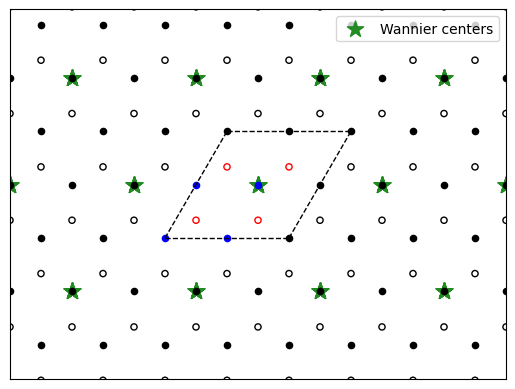

In [13]:
title = (
  "Haldane model \n"
  fr"$C = {chern: .1f}$, $\Delta = {delta}$, $t= {t: .2f}, t_2 = {t2: .2f}$"
  )

kwargs_centers = {'s': 150, 'marker':'*', 'c':'forestgreen', 'alpha':1} 
kwargs_omit = {'s': 80, 'marker':'x', 'c':'k'} 
kwargs_lat = {'s': 20, 'marker':'o', 'c':'k'} 

fig, ax = plot_centers(
    WF, title=title, omit_sites=[omit_sites], mark_home_cell=True, translate_centers=True, 
    kwargs_centers=kwargs_centers, kwargs_lat=kwargs_lat, kwargs_omit=kwargs_omit, legend=True)

ax[0].plot([.5, 2.5], [0.28867513, 0.28867513], c='k', ls='--', lw=1)
ax[0].plot([.5, 1.5], [0.28867513, 1.15470054+0.866], c='k', ls='--', lw=1)
ax[0].plot([1.5, 3.5], [1.15470054+0.866, 1.15470054+0.866], c='k', ls='--', lw=1)
ax[0].plot([2.5, 3.5], [0.28867513, 1.15470054+0.866], c='k', ls='--', lw=1)

ax[0].set_xlim(-2, 6)
ax[0].set_ylim(-2, 4)

ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_title('')

save_name = f"images/Wan_centers_C={chern:.1f}_delta={delta:.1f}_t={t:.1f}_t2={t2:.1f}_twfs={np.array(tf_list, dtype=int)}.png"
plt.savefig(save_name, dpi=700)